# Sprint　機械学習スクラッチ　線形回帰  
＜目的＞
- スクラッチを通して線形回帰を理解する
- オブジェクト指向を意識した実装に慣れる
- 数式をコードに落とし込めるようにする  

線形回帰のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。

### 【問題1】仮定関数  
以下の数式で表される線形回帰の仮定関数を実装してください。メソッドの雛形を用意してあります。

$$
h_\theta(x)=\theta_0x_0+\theta_1x_1+...+\theta_jx_j+...+\theta_nx_n (x_0=1)
$$

$\boldsymbol{x}$ : 特徴量ベクトル  
$\theta$ : パラメータベクトル  
$n$ : 特徴量の数  
$x_j$ : j番目の特徴量  
$\theta_j$ : j番目のパラメータ（重み）  

特徴量の数$n$は任意の値に対応できる実装にしてください。  
なお、ベクトル形式で表すと以下のようになります。 

$$
h_\theta(x)=\theta^T\boldsymbol{x}
$$

### 【問題2】最降下法  
最急降下法により学習させる実装を行なってください。以下の式で表されるパラメータの更新式のメソッド_gradient_descentを追加し、fitメソッドから呼び出すようにしてください。

$$
\theta_j:=\theta_j-\alpha\frac{1}{m}\sum_{i=1}^{m}[(h_\theta(x^{(i)})-y^{(i)}x_j^{(i)}]
$$

$\alpha$ : 学習率  
$i$ : サンプルのインデックス  
$j$ : 特徴量のインデックス  

### 【問題3】推定  
推定する仕組みを実装してください。ScratchLinearRegressionクラスの雛形に含まれるpredictメソッドに書き加えてください。
仮定関数 $h_\theta(x)$ の出力が推定結果です。

### 【問題4】平均二乗誤差  
線形回帰の指標値として用いられる平均二乗誤差（mean square error, MSE）の関数を作成してください。
平均二乗誤差関数は回帰問題全般で使える関数のため、ScratchLinearRegressionクラスのメソッドではなく、別の関数として作成してください。雛形を用意してあります。
平均二乗誤差は以下の数式で表されます。

$$
L(\theta)=\frac{1}{m}\sum_{i=1}^{m}(h_\theta(x^{(i)})-y^{(i)})^2
$$

$m$ : 入力されるデータの数  
$h_\theta()$ : 仮定関数  
$x^{(i)}$ : i番目のサンプルの特徴量ベクトル  
$y^{(i)}$ : i番目のサンプルの正解値 

なお、最急降下法のための目的関数（損失関数）としては、これを2で割ったものを使用します。（問題5, 9）

### 【問題5】目的関数  
以下の数式で表される線形回帰の **目的関数（損失関数）** を実装してください。そして、これを``self.loss``, ``self.val_loss``に記録するようにしてください。  
目的関数（損失関数）$J(\theta)$ は次の式です。

$$
J(\theta)=\frac{1}{2m}\sum_{i=1}^{m}(h_\theta(x^{(i)})-y^{(i)})^2
$$

$m$ : 入力されるデータの数  
$h_\theta()$ : 仮定関数  
$x^{(i)}$ : i番目のサンプルの特徴量ベクトル  
$y^{(i)}$ : i番目のサンプルの正解値 

In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from IPython.display import Image

In [2]:
class ScratchLinearRegression():
    """
    線形回帰のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    no_bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      訓練データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証データに対する損失の記録

    """
    def __init__(self, num_iter, lr, no_bias, verbose):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.no_bias = no_bias
        self.verbose = verbose
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)
        
    def _linear_hypothesis(self, X, Theta):
        """
   　　 線形の仮定関数を計算する

    　　Parameters
    　　----------
    　　X : 次の形のndarray, shape (n_samples, n_features)
      　　訓練データ
    　　Theta ：次の形のndarray, shape (n_features, 1)
      　　仮説のパラメーター
    
    　　Returns
    　　-------
      　　次の形のndarray, shape (n_samples, 1)
      　　線形の仮定関数による推定結果

    　　"""
        predict = X@Theta
        return predict
    
    def _gradient_descent(self, X, y, X_val, y_val, Theta, alpha, max_iter):
        """
    　　最急降下法によりThetaを更新する

    　　Parameters
    　　----------
    　　X : 次の形のndarray, shape (n_samples, n_features)
      　　訓練データ
    　　y : 次の形のndarray, shape (n_samples, 1)
      　　正解データ
    　　Theta : 次の形のndarray, shape (n_features, 1)
      　　仮説のパラメーター
    　　self.lr : scaler
      　　学習率
    　　self.iter : scaler
      　　最大の学習回数
    
    　　Returns
    　　-------
      　Theta : 次の形のndarray, shape (n_samples, 1)
      　　線形の仮定関数による推定結果
        self.loss : 次の形のndarray, shape (self.iter,)
          訓練データに対する損失の記録
        self.val_loss : 次の形のndarray, shape (self.iter,)
          検証データに対する損失の記録
          
    　　"""
        m = np.shape(X)[0]
        if X_val is not None and y_val is not None:
            m_val = np.shape(X_val)[0]
        else:
            pass
        
        for i in range(max_iter):
            y_pred = self._linear_hypothesis(X, Theta)
            self.loss[i] = self.MSE(y_pred, y)/2
            if X_val is not None and y_val is not None:
                y_val_pred = self._linear_hypothesis(X_val, Theta)
                self.val_loss[i] = self.MSE(y_val_pred, y_val)/2
            else:
                pass
            
            Theta -= alpha/m * (X.T@(y_pred - y[:, np.newaxis]))
        
        return Theta, self.loss, self.val_loss
    
    def MSE(self, y_pred, y):
        """
        平均二乗誤差の計算

        Parameters
        ----------
        y_pred : 次の形のndarray, shape (n_samples,)
          推定した値
        y : 次の形のndarray, shape (n_samples,)
          正解値

        Returns
        ----------
        mse : numpy.float
          平均二乗誤差
        """
        m = np.shape(y)[0]
        mse = (y_pred.flatten() - y).T @ (y_pred.flatten() - y) / m
        return mse
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        線形回帰を学習する。検証データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        m, n = np.shape(X)
        self.y = y
        if self.no_bias == True:
            self.X = X
            self.Theta = np.random.rand(n, 1)
        else:
            self.X = np.hstack([np.ones([m, 1]), X])
            self.Theta = np.random.rand(n+1, 1)
        
        if X_val is not None and y_val is not None:
            m_val = np.shape(X_val)[0]
            self.y_val = y_val
            if self.no_bias == True:
                self.X_val = X_val
            else:
                self.X_val = np.hstack([np.ones([m_val, 1]), X_val])
        else:
            self.X_val = None
            self.y_val = None

        self.coef_, self.loss, self.val_loss = self._gradient_descent(
            self.X, self.y, self.X_val, self.y_val, self.Theta, self.lr, self.iter)
        
        if self.verbose == True:
            print("loss(train):\n{}\n".format(self.loss))
            print("loss(validation):\n{}\n".format(self.val_loss))
        else:
            pass
        
    def predict(self, X):
        """
        線形回帰を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            線形回帰による推定結果
        """
        m, n = np.shape(X)
        if self.no_bias == True:
            self.X = X
        else:
            self.X = np.hstack([np.ones([m, 1]), X])
        
        pred = self.X @ self.Theta
        return pred

### 【問題6】学習と推定  
機械学習スクラッチ入門のSprintで用意したHouse Pricesコンペティションのデータに対してスクラッチ実装の学習と推定を行なってください。
scikit-learnによる実装と比べ、正しく動いているかを確認してください。

In [3]:
# データの読み込み
data = pd.read_csv('train.csv')
df_house = data[['GrLivArea', 'YearBuilt', 'SalePrice']]
print('< House Price >')
display(df_house.head())
display(np.shape(df_house))

< House Price >


,GrLivArea,YearBuilt,SalePrice
0,1710,2003,208500
1,1262,1976,181500
2,1786,2001,223500
3,1717,1915,140000
4,2198,2000,250000


(1460, 3)

In [4]:
# データ取得
X = df_house.iloc[:, :-1].values
y = df_house.iloc[:, -1].values

# 分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=1, train_size=0.75)

# 回帰のため、目的変数も標準化
sc_x = StandardScaler()
sc_y = StandardScaler()
sc_x.fit(X_train)
sc_y.fit(y_train[:, np.newaxis])
X_train_std = sc_x.transform(X_train)
X_test_std = sc_x.transform(X_test)
y_train_std = sc_y.transform(y_train[:, np.newaxis]).flatten()
y_test_std = sc_y.transform(y_test[:, np.newaxis]).flatten()

# 可視化のため変数毎に分割
X1_train_std = X_train_std[:, 0][:, np.newaxis]
X2_train_std = X_train_std[:, 1][:, np.newaxis]

In [5]:
# 回帰問題可視化関数
def regression_visualize(X, y, model_name='model', models=[], titles=[], colors=[], xlabels=[], ylabel='y'):
    print("< {} >".format(model_name))
    n_var = np.shape(X)[1]
    fig,ax = plt.subplots(nrows=1,ncols=n_var,figsize=(12,3*n_var))
    for i in range(n_var):
        x = X[:, i][:, np.newaxis]
        y_pred = models[i].predict(x).flatten()
        plt.subplot(1,n_var,i+1)
        plt.scatter(x, y, color=colors[i], edgecolor='white')
        plt.plot(x, y_pred, color='black')
        plt.title("{}".format(titles[i]))
        plt.xlabel('{}'.format(xlabels[i]))
        plt.ylabel('{}'.format(ylabel))   
    plt.show()

### 1. scirkit-lean

=== Linear Regression (scirkit-lean) ===

< train data >


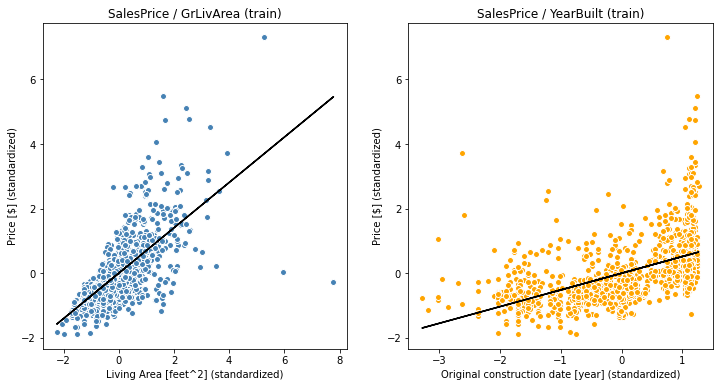

< test data >


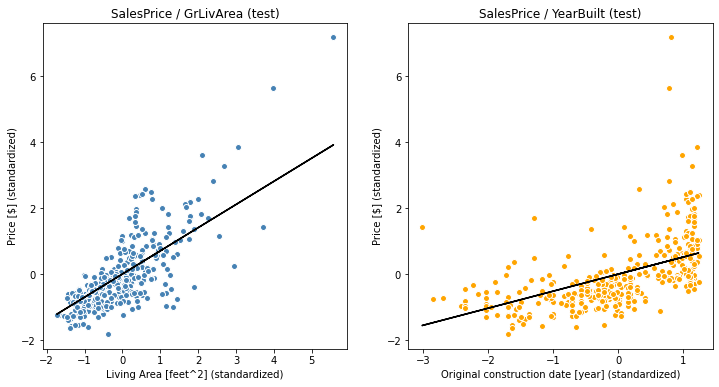

< Metrics (test data) >
MSE : 0.303
R^2 : 0.722


In [6]:
# 線形回帰(scirkit learn)
print("=== Linear Regression (scirkit-lean) ===\n")

# 可視化のため変数毎と全体の3つを学習
sgr = SGDRegressor()
sgr_1 = SGDRegressor()
sgr_2 = SGDRegressor()
sgr.fit(X_train_std, y_train_std)
sgr_1.fit(X1_train_std, y_train_std)
sgr_2.fit(X2_train_std, y_train_std)

# 可視化
# 訓練データ
regression_visualize(X_train_std, y_train_std, 
                     model_name='train data', 
                     models=[sgr_1, sgr_2], 
                     titles=['SalesPrice / GrLivArea (train)', 'SalesPrice / YearBuilt (train)'],
                     colors=['steelblue', 'orange'],
                     xlabels=['Living Area [feet^2] (standardized)', 'Original construction date [year] (standardized)'],
                     ylabel='Price [$] (standardized)')
# 検証データ
regression_visualize(X_test_std, y_test_std, 
                     model_name='test data', 
                     models=[sgr_1, sgr_2], 
                     titles=['SalesPrice / GrLivArea (test)', 'SalesPrice / YearBuilt (test)'],
                     colors=['steelblue', 'orange'],
                     xlabels=['Living Area [feet^2] (standardized)', 'Original construction date [year] (standardized)'],
                     ylabel='Price [$] (standardized)')

# 評価(平均二乗誤差、決定係数)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("< Metrics (test data) >")
y_test_pred = sgr.predict(X_test_std)
MSE = mean_squared_error(y_test_std, y_test_pred)
print('MSE : {:.3f}'.format(MSE))
R2 = r2_score(y_test_std, y_test_pred)
print('R^2 : {:.3f}'.format(R2))

### 2. scratch

=== Liner Regression (Scratch / Bias(+)) ===

loss(train):
[0.24094191 0.22097809 0.20828044 0.20018146 0.19500113 0.19167835
 0.1895411  0.18816257 0.18727095 0.18669267 0.18631658 0.18607132
 0.18591094 0.18580578 0.18573664 0.18569106 0.18566094 0.18564098
 0.18562771 0.18561888 0.18561298 0.18560903 0.18560637 0.18560459
 0.18560339 0.18560258 0.18560203 0.18560165 0.1856014  0.18560123
 0.18560111 0.18560103 0.18560097 0.18560094 0.18560091 0.18560089
 0.18560088 0.18560087 0.18560087 0.18560086 0.18560086 0.18560086
 0.18560086 0.18560085 0.18560085 0.18560085 0.18560085 0.18560085
 0.18560085 0.18560085 0.18560085 0.18560085 0.18560085 0.18560085
 0.18560085 0.18560085 0.18560085 0.18560085 0.18560085 0.18560085
 0.18560085 0.18560085 0.18560085 0.18560085 0.18560085 0.18560085
 0.18560085 0.18560085 0.18560085 0.18560085 0.18560085 0.18560085
 0.18560085 0.18560085 0.18560085 0.18560085 0.18560085 0.18560085
 0.18560085 0.18560085 0.18560085 0.18560085 0.18560085 0.18560085
 0.

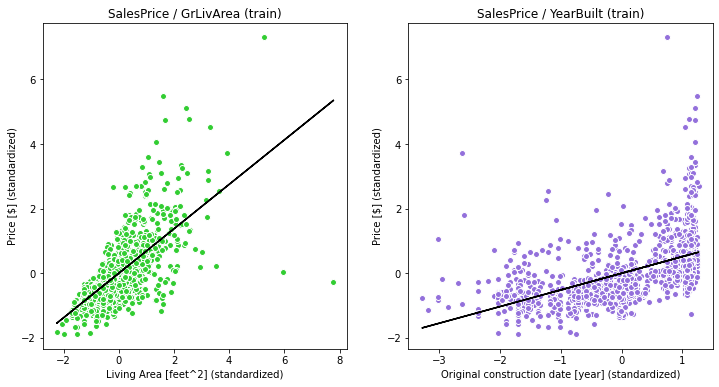

< test data >


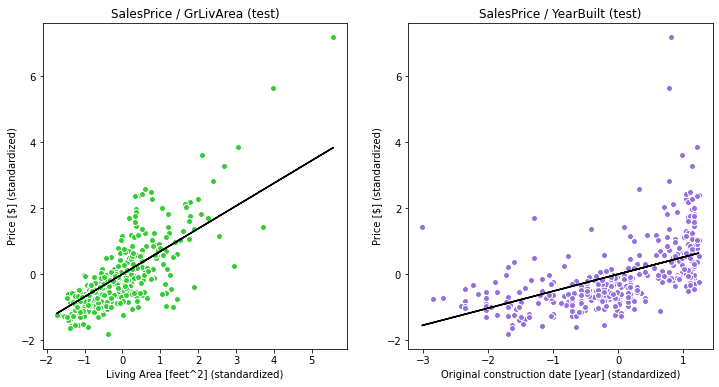

< Metrics (test data) >
MSE : 0.306
R^2 : 0.719


In [7]:
# 線形回帰(スクラッチ, Bias(+))
print("=== Liner Regression (Scratch / Bias(+)) ===\n")

# スクラッチ実装のインスタンス作成
slr = ScratchLinearRegression(num_iter=100, lr=0.2, no_bias=False, verbose=True)
slr_1 = ScratchLinearRegression(num_iter=100, lr=0.2, no_bias=False, verbose=False)
slr_2 = ScratchLinearRegression(num_iter=100, lr=0.2, no_bias=False, verbose=False)

# 学習・誤差関数の出力
slr.fit(X_train_std, y_train_std, X_test_std, y_test_std)
slr_1.fit(X1_train_std, y_train_std)
slr_2.fit(X2_train_std, y_train_std)

# 可視化
# 訓練データ
regression_visualize(X_train_std, y_train_std, 
                     model_name='train data', 
                     models=[slr_1, slr_2], 
                     titles=['SalesPrice / GrLivArea (train)', 'SalesPrice / YearBuilt (train)'],
                     colors=['limegreen', 'mediumpurple'],
                     xlabels=['Living Area [feet^2] (standardized)', 'Original construction date [year] (standardized)'],
                     ylabel='Price [$] (standardized)')
# 検証データ
regression_visualize(X_test_std, y_test_std, 
                     model_name='test data', 
                     models=[slr_1, slr_2], 
                     titles=['SalesPrice / GrLivArea (test)', 'SalesPrice / YearBuilt (test)'],
                     colors=['limegreen', 'mediumpurple'],
                     xlabels=['Living Area [feet^2] (standardized)', 'Original construction date [year] (standardized)'],
                     ylabel='Price [$] (standardized)')

# 評価(平均二乗誤差、決定係数)
print("< Metrics (test data) >")
y_test_pred = slr.predict(X_test_std)
MSE = mean_squared_error(y_test_std, y_test_pred)
print('MSE : {:.3f}'.format(MSE))
R2 = r2_score(y_test_std, y_test_pred)
print('R^2 : {:.3f}'.format(R2))

- 可視化された仮説や評価指標の値をみると、scirkit-leanと変わらない挙動のようだ

### 【問題7】学習曲線のプロット  
学習曲線を表示する関数を作成し、実行してください。グラフを見て損失が適切に下がっているかどうか確認してください。
線形回帰クラスの雛形ではself.loss, self.val_lossに損失を記録しておくようになっているため、入力にはこれを利用してください。

In [8]:
# 学習曲線のプロット
def learning_curve(n_iter, loss, val_loss):
    plt.plot(np.arange(n_iter), loss, label='train_loss')
    plt.plot(np.arange(n_iter), val_loss, label='val_loss')
    plt.title('model loss')
    plt.xlabel('iter')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

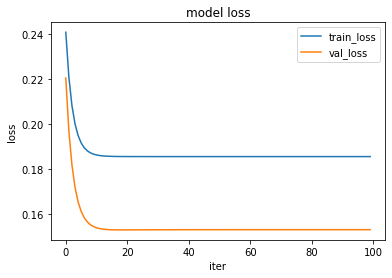

In [9]:
# 上記の学習で実行(Bias(+))
learning_curve(100, slr.loss, slr.val_loss)

- iter毎に訓練・検証データともに誤差が低下しているため、学習率は適切のようだ
- はじめから検証データの誤差の方が小さいのは、訓練データの方に外れ値が多く含まれているためだと思われる

### 【問題8】バイアス項の除去  
バイアス項 $\theta_0$ を抜くと学習がどう変化するか検証してください。また、線形回帰モデルにおけるバイアス項の役割の考察・調査を行ってください。

=== Linear Regression (Scratch / Bias(-)) ===

loss(train):
[0.24093062 0.22424701 0.21260828 0.20448302 0.19880713 0.19484022
 0.19206655 0.1901265  0.18876913 0.1878192  0.18715428 0.18668877
 0.18636282 0.18613456 0.18597471 0.18586274 0.18578432 0.18572938
 0.1856909  0.18566394 0.18564505 0.18563182 0.18562255 0.18561605
 0.1856115  0.18560832 0.18560608 0.18560452 0.18560342 0.18560265
 0.18560211 0.18560174 0.18560147 0.18560129 0.18560116 0.18560107
 0.185601   0.18560096 0.18560093 0.1856009  0.18560089 0.18560088
 0.18560087 0.18560086 0.18560086 0.18560086 0.18560086 0.18560086
 0.18560085 0.18560085 0.18560085 0.18560085 0.18560085 0.18560085
 0.18560085 0.18560085 0.18560085 0.18560085 0.18560085 0.18560085
 0.18560085 0.18560085 0.18560085 0.18560085 0.18560085 0.18560085
 0.18560085 0.18560085 0.18560085 0.18560085 0.18560085 0.18560085
 0.18560085 0.18560085 0.18560085 0.18560085 0.18560085 0.18560085
 0.18560085 0.18560085 0.18560085 0.18560085 0.18560085 0.18560085
 0

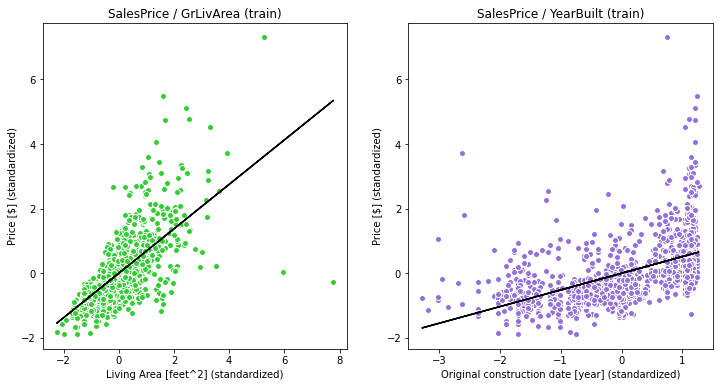

< test data >


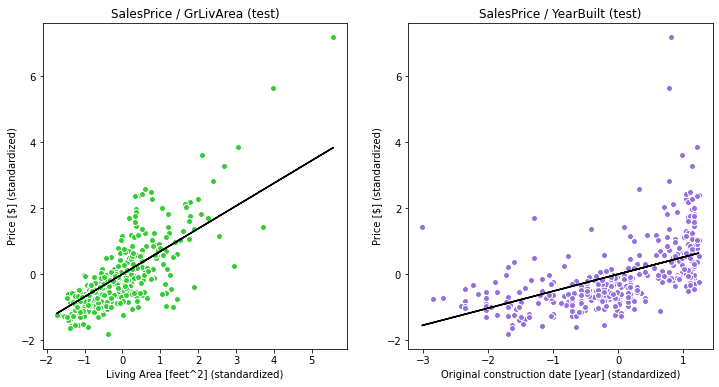

< Metrics (test data) >
MSE : 0.306
R^2 : 0.719


In [10]:
# 線形回帰(スクラッチ, Bias(-))
print("=== Linear Regression (Scratch / Bias(-)) ===\n")

# スクラッチ実装のインスタンス作成
slr_nb = ScratchLinearRegression(num_iter=100, lr=0.2, no_bias=True, verbose=True)
slr_1_nb = ScratchLinearRegression(num_iter=100, lr=0.2, no_bias=True, verbose=False)
slr_2_nb = ScratchLinearRegression(num_iter=100, lr=0.2, no_bias=True, verbose=False)

# 学習・誤差関数の出力
slr_nb.fit(X_train_std, y_train_std, X_test_std, y_test_std)
slr_1_nb.fit(X1_train_std, y_train_std)
slr_2_nb.fit(X2_train_std, y_train_std)

# 可視化
# 訓練データ
regression_visualize(X_train_std, y_train_std, 
                     model_name='train data', 
                     models=[slr_1_nb, slr_2_nb], 
                     titles=['SalesPrice / GrLivArea (train)', 'SalesPrice / YearBuilt (train)'],
                     colors=['limegreen', 'mediumpurple'],
                     xlabels=['Living Area [feet^2] (standardized)', 'Original construction date [year] (standardized)'],
                     ylabel='Price [$] (standardized)')
# 検証データ
regression_visualize(X_test_std, y_test_std, 
                     model_name='test data', 
                     models=[slr_1_nb, slr_2_nb], 
                     titles=['SalesPrice / GrLivArea (test)', 'SalesPrice / YearBuilt (test)'],
                     colors=['limegreen', 'mediumpurple'],
                     xlabels=['Living Area [feet^2] (standardized)', 'Original construction date [year] (standardized)'],
                     ylabel='Price [$] (standardized)')

# 評価(平均二乗誤差、決定係数)
print("< Metrics (test data) >")
y_test_pred = slr_nb.predict(X_test_std)
MSE = mean_squared_error(y_test_std, y_test_pred)
print('MSE : {:.3f}'.format(MSE))
R2 = r2_score(y_test_std, y_test_pred)
print('R^2 : {:.3f}'.format(R2))

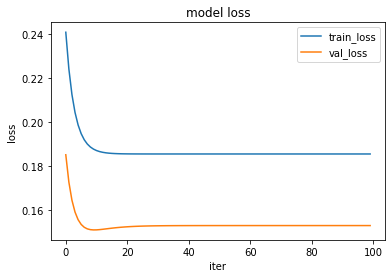

In [11]:
# 学習曲線(Bias(-))
learning_curve(100, slr_nb.loss, slr_nb.val_loss)

- 今回のデータでは、Biasの有無で仮説に大きな違いは見られなかった
- Biasがなければ仮説の直線は原点を通るものに限定されるため、表現力が低下する
- しかし今回は説明変数・目的変数の全てを標準化しているため、Biasの有無で仮説や誤差に違いがほとんど見られなかったものと思われる

### 【問題9】特徴量の多次元化  
特徴量の二乗や三乗を入力に利用すると学習結果がどう変化するか検証してください。

In [12]:
# 2乗のデータ取得
X = df_house.iloc[:, :-1].values
X = X**2
y = df_house.iloc[:, -1].values

# 分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=1, train_size=0.75)

# 回帰のため、目的変数も標準化
sc_x = StandardScaler()
sc_y = StandardScaler()
sc_x.fit(X_train)
sc_y.fit(y_train[:, np.newaxis])
X_train_std = sc_x.transform(X_train)
X_test_std = sc_x.transform(X_test)
y_train_std = sc_y.transform(y_train[:, np.newaxis]).flatten()
y_test_std = sc_y.transform(y_test[:, np.newaxis]).flatten()

# 可視化のため変数毎に分割
X1_train_std = X_train_std[:, 0][:, np.newaxis]
X2_train_std = X_train_std[:, 1][:, np.newaxis]

=== Liner Regression (Scratch / Bias(+)) ===
< squared features >

loss(train):
[0.6515223  0.49068326 0.3896496  0.32609546 0.28606227 0.26081057
 0.24486096 0.23477322 0.22838444 0.22433294 0.22176027 0.22012451
 0.21908311 0.21841926 0.21799554 0.21772474 0.21755145 0.21744042
 0.21736919 0.21732344 0.21729401 0.21727506 0.21726285 0.21725496
 0.21724986 0.21724656 0.21724442 0.21724303 0.21724213 0.21724154
 0.21724116 0.21724091 0.21724075 0.21724064 0.21724057 0.21724053
 0.2172405  0.21724048 0.21724046 0.21724045 0.21724045 0.21724044
 0.21724044 0.21724044 0.21724044 0.21724044 0.21724044 0.21724044
 0.21724044 0.21724044 0.21724044 0.21724044 0.21724044 0.21724044
 0.21724044 0.21724044 0.21724044 0.21724044 0.21724044 0.21724044
 0.21724044 0.21724044 0.21724044 0.21724044 0.21724044 0.21724044
 0.21724044 0.21724044 0.21724044 0.21724044 0.21724044 0.21724044
 0.21724044 0.21724044 0.21724044 0.21724044 0.21724044 0.21724044
 0.21724044 0.21724044 0.21724044 0.21724044 0.21

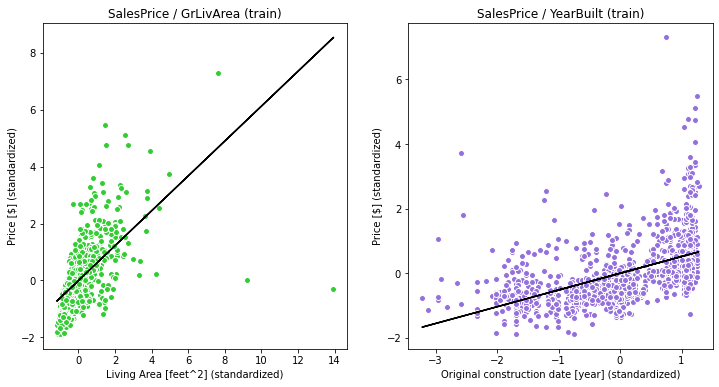

< test data >


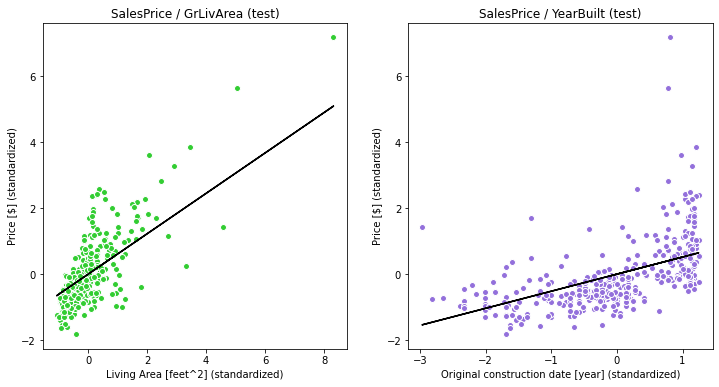

< Metrics (test data) >
MSE : 0.298
R^2 : 0.726


In [13]:
# 2乗データの線形回帰(スクラッチ, Bias(+))
print("=== Liner Regression (Scratch / Bias(+)) ===")
print("< squared features >\n")

# スクラッチ実装のインスタンス作成
slr_s = ScratchLinearRegression(num_iter=100, lr=0.2, no_bias=False, verbose=True)
slr_1_s = ScratchLinearRegression(num_iter=100, lr=0.2, no_bias=False, verbose=False)
slr_2_s = ScratchLinearRegression(num_iter=100, lr=0.2, no_bias=False, verbose=False)

# 学習・誤差関数の出力
slr_s.fit(X_train_std, y_train_std, X_test_std, y_test_std)
slr_1_s.fit(X1_train_std, y_train_std)
slr_2_s.fit(X2_train_std, y_train_std)

# 可視化
# 訓練データ
regression_visualize(X_train_std, y_train_std, 
                     model_name='train data', 
                     models=[slr_1_s, slr_2_s], 
                     titles=['SalesPrice / GrLivArea (train)', 'SalesPrice / YearBuilt (train)'],
                     colors=['limegreen', 'mediumpurple'],
                     xlabels=['Living Area [feet^2] (standardized)', 'Original construction date [year] (standardized)'],
                     ylabel='Price [$] (standardized)')
# 検証データ
regression_visualize(X_test_std, y_test_std, 
                     model_name='test data', 
                     models=[slr_1_s, slr_2_s], 
                     titles=['SalesPrice / GrLivArea (test)', 'SalesPrice / YearBuilt (test)'],
                     colors=['limegreen', 'mediumpurple'],
                     xlabels=['Living Area [feet^2] (standardized)', 'Original construction date [year] (standardized)'],
                     ylabel='Price [$] (standardized)')

# 評価(平均二乗誤差、決定係数)
print("< Metrics (test data) >")
y_test_pred = slr_s.predict(X_test_std)
MSE = mean_squared_error(y_test_std, y_test_pred)
print('MSE : {:.3f}'.format(MSE))
R2 = r2_score(y_test_std, y_test_pred)
print('R^2 : {:.3f}'.format(R2))

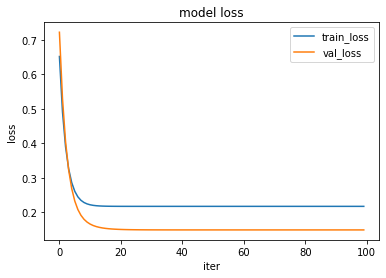

In [14]:
# 学習曲線(2乗データ、Bias(+))
learning_curve(100, slr_s.loss, slr_s.val_loss)

- 特徴量を2乗した後に標準化して学習したが、今回の検証では2乗の有無で仮説や指標値に大きな変化はみられなかった
- 標準化により、特徴量の変化が顕著に表れなかった可能性は考えられる
- 2乗していない元のデータの散布図をみると、二次関数の仮説の方がむしろ直線の仮説よりも適合しそうな印象はあったので、2乗しないモデルより少し良い指標値となっても不思議はないかと思われた

In [15]:
# 3乗のデータ取得
X = df_house.iloc[:, :-1].values
X = X**3
y = df_house.iloc[:, -1].values

# 分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=1, train_size=0.75)

# 回帰のため、目的変数も標準化
sc_x = StandardScaler()
sc_y = StandardScaler()
sc_x.fit(X_train)
sc_y.fit(y_train[:, np.newaxis])
X_train_std = sc_x.transform(X_train)
X_test_std = sc_x.transform(X_test)
y_train_std = sc_y.transform(y_train[:, np.newaxis]).flatten()
y_test_std = sc_y.transform(y_test[:, np.newaxis]).flatten()

# 可視化のため変数毎に分割
X1_train_std = X_train_std[:, 0][:, np.newaxis]
X2_train_std = X_train_std[:, 1][:, np.newaxis]

=== Liner Regression (Scratch / Bias(+)) ===
< cubed features >

loss(train):
[0.33852195 0.31973228 0.30715464 0.2987347  0.29309772 0.28932363
 0.28679665 0.28510459 0.28397154 0.28321277 0.28270463 0.28236431
 0.28213639 0.28198373 0.28188148 0.28181298 0.28176711 0.28173637
 0.28171579 0.281702   0.28169276 0.28168657 0.28168242 0.28167964
 0.28167778 0.28167653 0.2816757  0.28167514 0.28167476 0.28167451
 0.28167434 0.28167423 0.28167415 0.2816741  0.28167407 0.28167405
 0.28167403 0.28167402 0.28167401 0.28167401 0.28167401 0.281674
 0.281674   0.281674   0.281674   0.281674   0.281674   0.281674
 0.281674   0.281674   0.281674   0.281674   0.281674   0.281674
 0.281674   0.281674   0.281674   0.281674   0.281674   0.281674
 0.281674   0.281674   0.281674   0.281674   0.281674   0.281674
 0.281674   0.281674   0.281674   0.281674   0.281674   0.281674
 0.281674   0.281674   0.281674   0.281674   0.281674   0.281674
 0.281674   0.281674   0.281674   0.281674   0.281674   0.281674


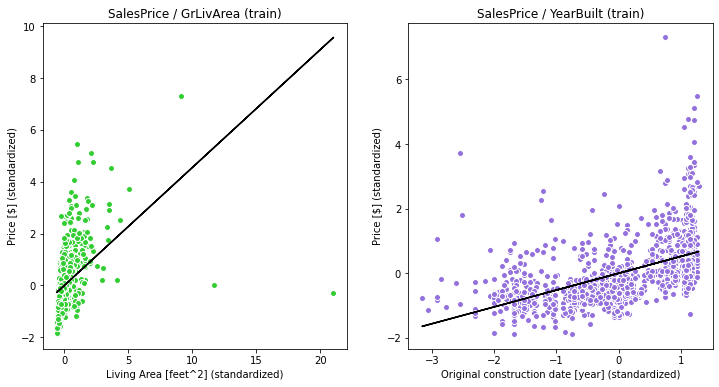

< test data >


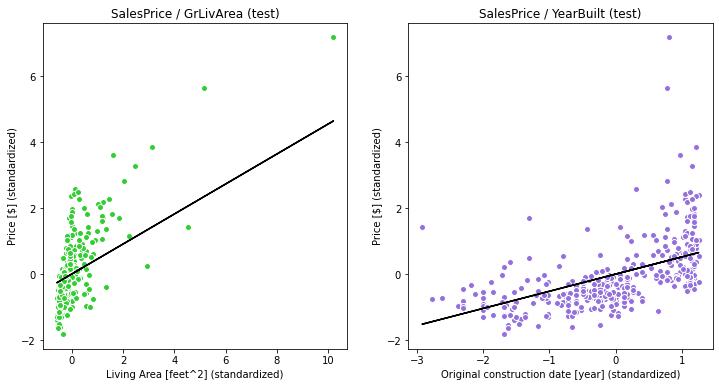

< Metrics (test data) >
MSE : 0.409
R^2 : 0.624


In [16]:
# 3乗データの線形回帰(スクラッチ, Bias(+))
print("=== Liner Regression (Scratch / Bias(+)) ===")
print("< cubed features >\n")

# スクラッチ実装のインスタンス作成
slr_c = ScratchLinearRegression(num_iter=100, lr=0.2, no_bias=False, verbose=True)
slr_1_c = ScratchLinearRegression(num_iter=100, lr=0.2, no_bias=False, verbose=False)
slr_2_c = ScratchLinearRegression(num_iter=100, lr=0.2, no_bias=False, verbose=False)

# 学習・誤差関数の出力
slr_c.fit(X_train_std, y_train_std, X_test_std, y_test_std)
slr_1_c.fit(X1_train_std, y_train_std)
slr_2_c.fit(X2_train_std, y_train_std)

# 可視化
# 訓練データ
regression_visualize(X_train_std, y_train_std, 
                     model_name='train data', 
                     models=[slr_1_c, slr_2_c], 
                     titles=['SalesPrice / GrLivArea (train)', 'SalesPrice / YearBuilt (train)'],
                     colors=['limegreen', 'mediumpurple'],
                     xlabels=['Living Area [feet^2] (standardized)', 'Original construction date [year] (standardized)'],
                     ylabel='Price [$] (standardized)')
# 検証データ
regression_visualize(X_test_std, y_test_std, 
                     model_name='test data', 
                     models=[slr_1_c, slr_2_c], 
                     titles=['SalesPrice / GrLivArea (test)', 'SalesPrice / YearBuilt (test)'],
                     colors=['limegreen', 'mediumpurple'],
                     xlabels=['Living Area [feet^2] (standardized)', 'Original construction date [year] (standardized)'],
                     ylabel='Price [$] (standardized)')

# 評価(平均二乗誤差、決定係数)
print("< Metrics (test data) >")
y_test_pred = slr_c.predict(X_test_std)
MSE = mean_squared_error(y_test_std, y_test_pred)
print('MSE : {:.3f}'.format(MSE))
R2 = r2_score(y_test_std, y_test_pred)
print('R^2 : {:.3f}'.format(R2))

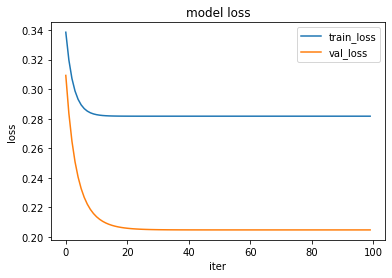

In [17]:
# 学習曲線(3乗データ、Bias(+))
learning_curve(100, slr_c.loss, slr_c.val_loss)

- 特徴量を3乗した後に標準化して学習した
- さすがに3乗まで来ると、住面積の特徴量は標準化しても特徴量の変化が強く出てくるようだ
- 築年の特徴量も値を確認すると変化していたが、標準化するとほとんど元の特徴量から変化していなかった
- 3次関数の仮説ではVarianceが大きくなり、また外れ値の誤差も大きくなってくるため、指標値が1次・2次の仮説と比較して低下したものと思われた

### 【問題10】更新式の導出  
最急降下法の更新式は以下でした。この式が導出される過程を説明してください。

$$
\theta_j:=\theta_j-\alpha\frac{1}{m}\sum_{i=1}^{m}[(h_\theta(x^{(i)})-y^{(i)})x_j^{(i)}]
$$

### ＜回答＞  
最小化したい目的関数 $J(\theta)$ は $\theta_{0}, \theta_{1}, ...\theta_{n}$ の関数であり、これを $\theta_j\:(j=0{\sim}n)$ で偏微分したものが $\theta_j$ を更新するための勾配となる。これを表した式が以下である。

$$
\theta_j:=\theta_j-\alpha\frac{\partial}{\partial\theta_j}J(\theta)\;\;-(*)
$$


$J(\theta)=\frac{1}{2m}\sum_{i=1}^{m}(h_\theta(x^{(i)})-y^{(i)})^2$より、$g(\theta)=(h_\theta(x)-y)^2$とみれば、合成関数の微分から
$$
\begin{align}
\frac{\partial}{\partial\theta_j}g(\theta)&=2(h_\theta(x)-y)\frac{\partial}{\partial\theta_j}h_\theta(x)\\
&=2(h_\theta(x)-y)\frac{\partial}{\partial\theta_j}(\theta_0x_0+\theta_1x_1+...+\theta_jx_j+...+\theta_nx_n)\\
&=2(h_\theta(x)-y)x_j
\end{align}
$$

となるので、

$$
\begin{align}
\frac{\partial}{\partial\theta_j}J(\theta)&=\frac{1}{2m}\sum_{i=1}^{m}\frac{\partial}{\partial\theta_j}g(\theta)\\
&=\frac{1}{2m}\sum_{i=1}^{m}2(h_\theta(x^{(i)})-y^{(i)})x_j^{(i)}\\
&=\frac{1}{m}\sum_{i=1}^{m}(h_\theta(x^{(i)})-y^{(i)})x_j^{(i)}
\end{align}
$$

となり、これを式(＊)に代入すれば、目的の式を得る。

### 【問題11】局所最適解の問題  
最急降下法には一般的に局所最適解の問題があります。しかし、線形回帰では学習を続ければ必ず最適解を求めることができます。それはなぜか数式やグラフを用いて説明してください。

### ＜回答＞  
線形回帰では、損失関数は以下のように $\theta$ の二次関数で表されている。

$$
J(\theta)=\frac{1}{2m}\sum_{i=1}^{m}(h_\theta(x^{(i)})-y^{(i)})^2
$$

上記の関数は、可視化のために$\theta_0$と$\theta_1$に限って表せば以下のような曲面となる。

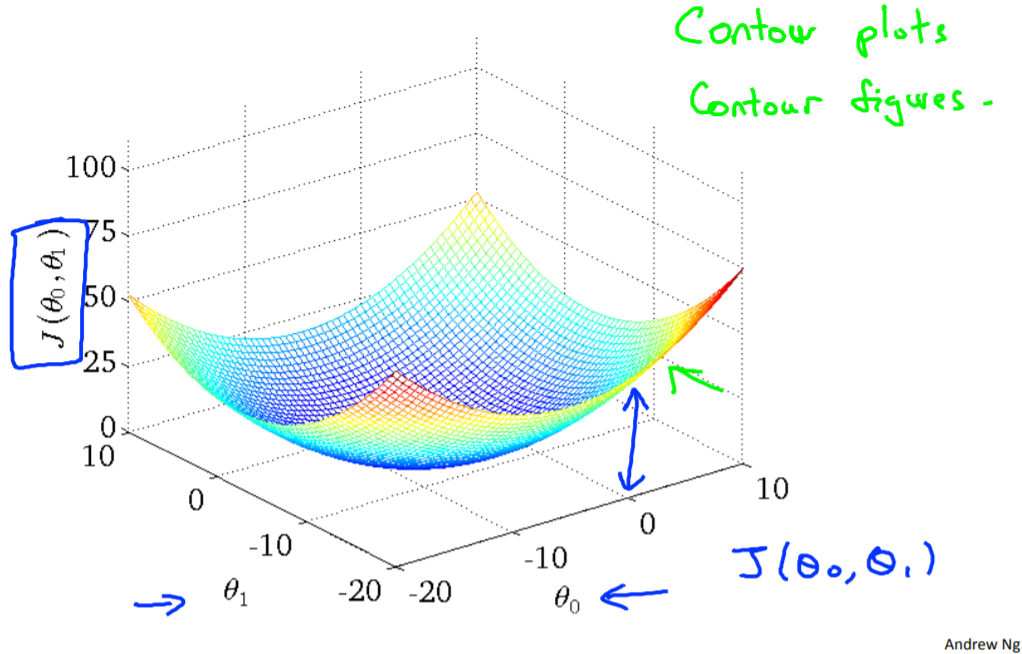

In [18]:
Image("5-2.png")

* Coursera Machine Lerning (Andrew Ng)より引用  

よって、勾配に沿って下降していけば最も高さの低い位置、つまり損失関数が最小となる位置にたどり着くことになる。これは変数$\theta$が増えても変わらない。

これは損失関数が二次関数であることによるので、損失関数が三次関数など極小値と最小値が必ずしも一致しない関数の場合には、下の図のように最降下法で収束したパラメータが全体の最適解ではなく、局所最適解となっている可能性がある。

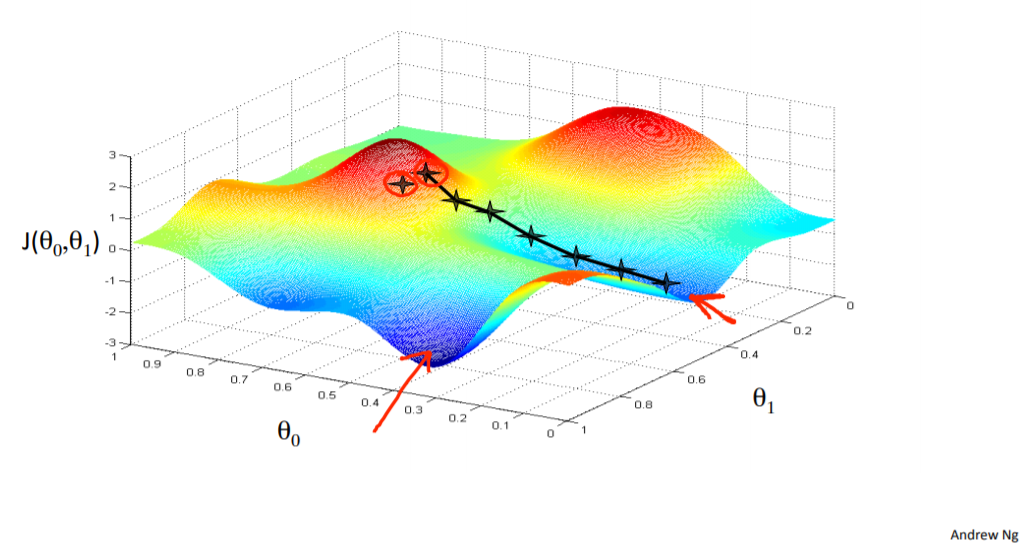

In [19]:
Image("5-3.png")

* Coursera Machine Lerning (Andrew Ng)より引用 